# Measure GRACE performance on identified objects:

All metrics here are **exact**, i.e measure similarity between two graphs formed of identical node count which have the same positions. The only thing that differs between the graphs is the edges and object membership / individual identities. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.metrics import (
    confusion_matrix, 
    precision_recall_fscore_support,
    jaccard_score,
)


In [3]:
from grace.base import GraphAttrs
from grace.models.optimiser import optimise_graph
from grace.simulator.simulate_graph import random_graph

from grace.evaluation.metrics import compute_metrics
from grace.evaluation.process import (
    generate_ground_truth_graph,
    update_graph_with_dummy_predictions, 
)
from grace.evaluation.visualisation import (
    plot_simple_graph,
    plot_connected_components
)


### Generate a random graph, update dummy labels & generate GT graph:

In [21]:
MOTIF = "circles"
N_MOTIFS = 3
DENSITY = 0.01

def generate_random_optimised_and_GT_graphs():
    G = random_graph(
        n_motifs=N_MOTIFS, 
        density=DENSITY, 
        motif=MOTIF
    )
    node_conf, edge_conf = 0.5, 0.1
    update_graph_with_dummy_predictions(
        G, 
        node_confidence=node_conf, 
        edge_confidence=edge_conf
    )
    true_graph = generate_ground_truth_graph(G)
    pred_graph = optimise_graph(G)

    return G, pred_graph, true_graph

## Keep making graphs until the prediction and GT come out different:

In [22]:
synthesize = True
counter = 0

while synthesize:
    counter += 1
    print (f"Synthesizing erroneous graph: iter = {counter}")

    G, pred_graph, true_graph = generate_random_optimised_and_GT_graphs()
    node_con = pred_graph.number_of_nodes() == true_graph.number_of_nodes()
    edge_con = pred_graph.number_of_edges() != true_graph.number_of_edges()
    
    if node_con and edge_con:
        synthesize = False


Synthesizing erroneous graph: iter = 1


## Visualise the resulting graphs:

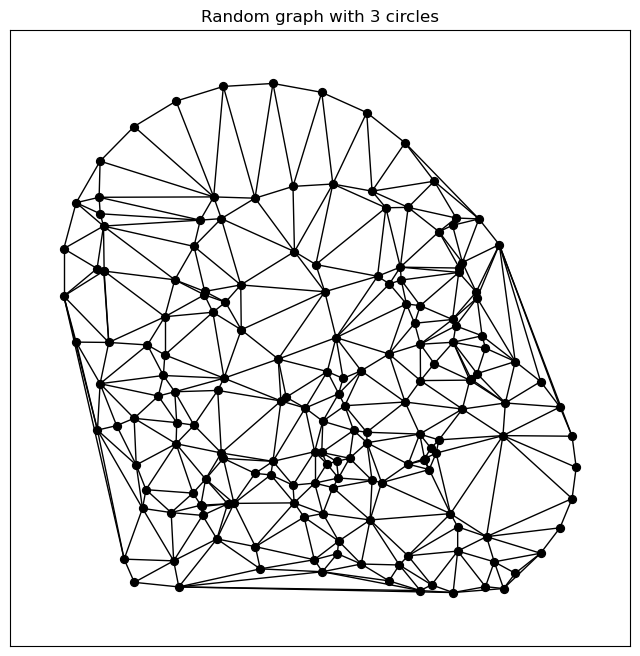

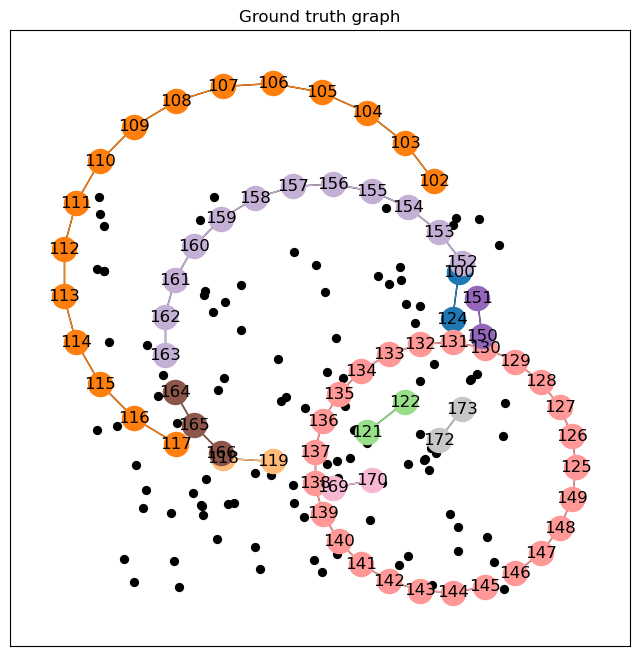

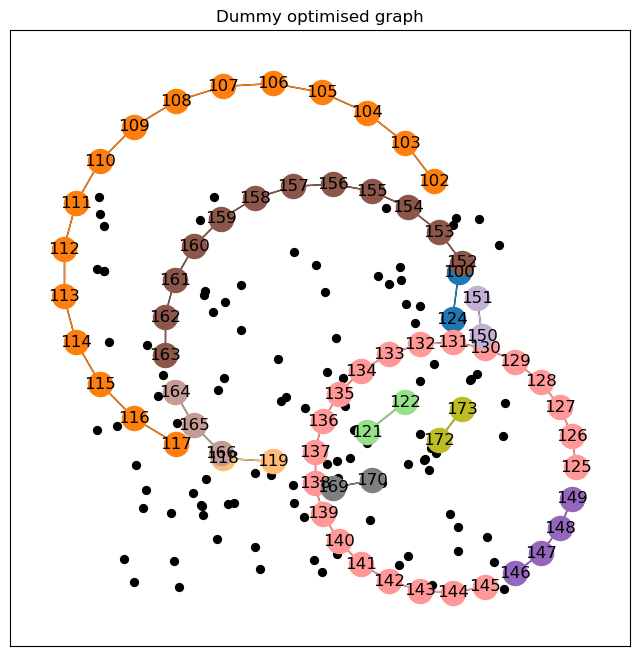

In [23]:
figsize = (8, 8)
plot_simple_graph(G, figsize=figsize, title=f"Random graph with {N_MOTIFS} {MOTIF}")
plot_connected_components(true_graph, figsize=figsize, title=f"Ground truth graph")
plot_connected_components(pred_graph, figsize=figsize, title=f"Dummy optimised graph")


## Evaluate the exact metrics:

Object detection metrics | Nodes
Accuracy  : 1.0000
Precision : 1.0000
Recall    : 1.0000
F1 Score  : 1.0000
Object detection metrics | Edges
Accuracy  : 0.9980
Precision : 1.0000
Recall    : 0.9821
F1 Score  : 0.9910
Intersection over Union
Semantic        : 1.0000
Instance [mean] : 0.9091
Instance [std]  : 0.2413


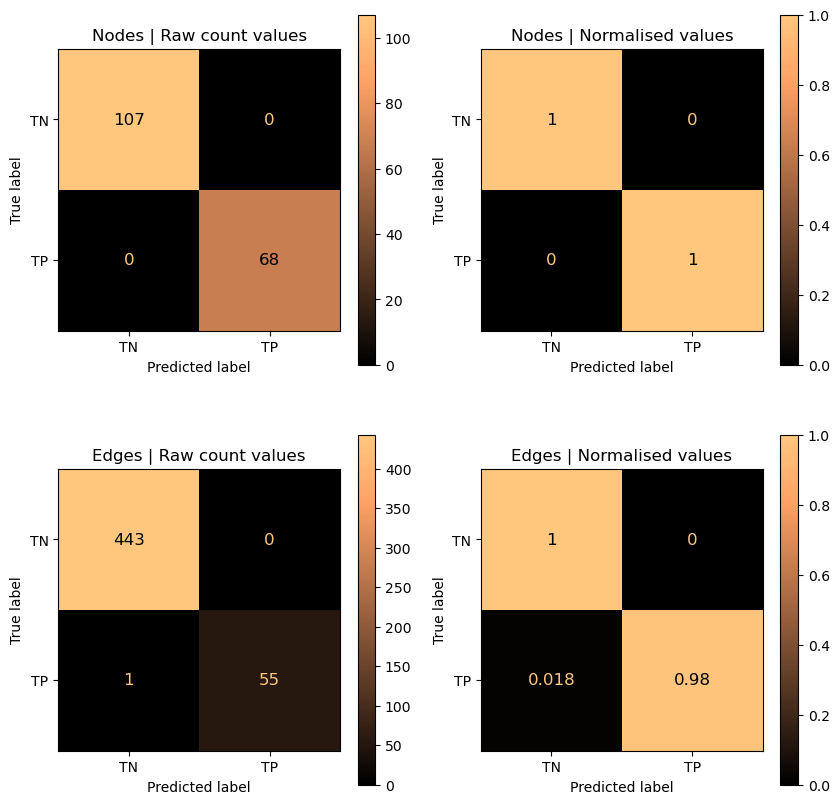

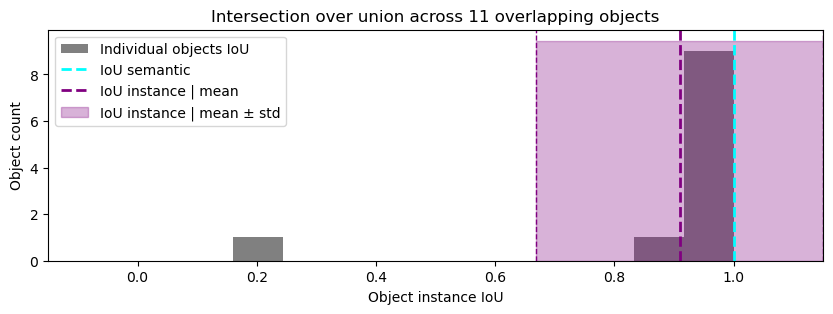

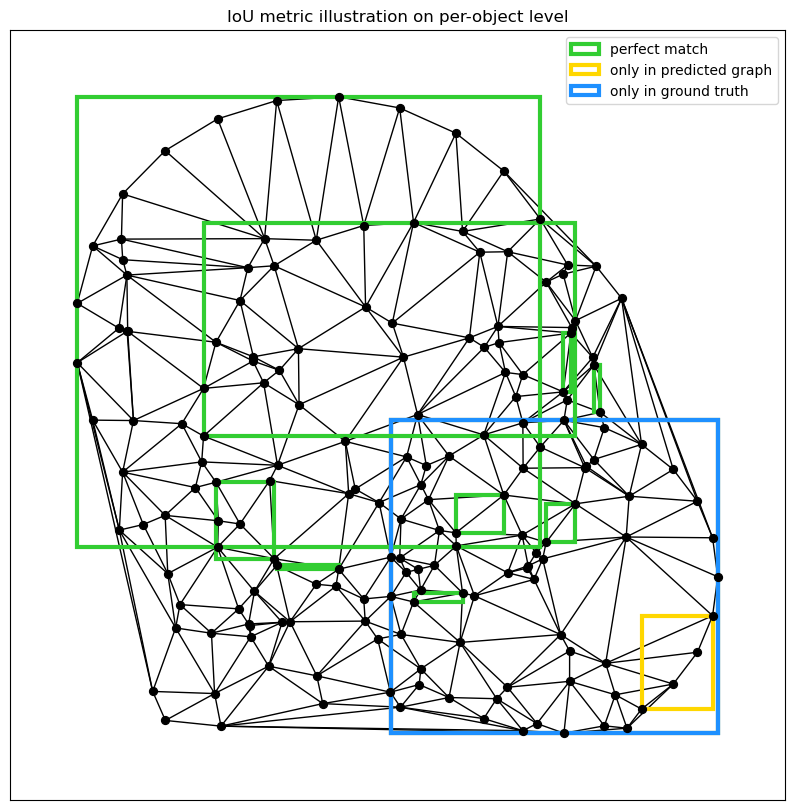

In [24]:
compute_metrics(G=G, pred_graph=pred_graph, true_graph=true_graph)

### Done!